In [3]:
# Standard Libraries
import pandas as pd
import numpy as np

# Scikit-learn for scaling and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)


In [4]:
# Load the CSV file
raw_data_path = "../data/raw/data.csv"  # Adjust path if needed
df = pd.read_csv(raw_data_path)

# Ensure datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Quick look at the data
df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


In [5]:
# Snapshot date: latest transaction date + 1 day
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)


Snapshot Date: 2019-02-14 10:01:28+00:00


In [6]:
# RFM Aggregation
rfm_df = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,  # Recency
    'CustomerId': 'count',                                             # Frequency
    'Amount': 'sum'                                                    # Monetary
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'CustomerId': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

# Quick check
rfm_df.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


In [7]:
# Standard scaling for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Create DataFrame for easy handling
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df['CustomerId'] = rfm_df['CustomerId']
rfm_scaled_df.head()


,Recency,Frequency,Monetary,CustomerId
0,1.937605,-0.253459,-0.066891,CustomerId_1
1,1.937605,-0.253459,-0.066891,CustomerId_10
2,2.158882,-0.212186,-0.055849,CustomerId_1001
3,-0.201408,-0.150278,-0.061655,CustomerId_1002
4,-0.717722,-0.201868,-0.055849,CustomerId_1003


In [8]:
# Cluster customers into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster summary to identify high-risk cluster
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("Cluster Summary:\n", cluster_summary)


Cluster Summary:
            Recency    Frequency      Monetary
Cluster                                      
0        61.859846     7.726699  8.172379e+04
1        29.000000  4091.000000 -1.049000e+08
2        12.716076    34.807692  2.726546e+05


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


In [9]:
# High-risk = highest Recency, lowest Frequency & Monetary
# Use Recency primarily
high_risk_cluster = cluster_summary['Recency'].idxmax()
print("High-risk cluster:", high_risk_cluster)

# Assign binary target
rfm_df['is_high_risk'] = (rfm_df['Cluster'] == high_risk_cluster).astype(int)

# Check
rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'is_high_risk']].head()


High-risk cluster: 0


,CustomerId,Recency,Frequency,Monetary,Cluster,is_high_risk
0,CustomerId_1,84,1,-10000.0,0,1
1,CustomerId_10,84,1,-10000.0,0,1
2,CustomerId_1001,90,5,20000.0,0,1
3,CustomerId_1002,26,11,4225.0,2,0
4,CustomerId_1003,12,6,20000.0,2,0


In [10]:
# For demonstration, let's assume processed_df is the output of Task 3
# If you already have your feature-engineered dataframe, use that instead

# Example: starting from raw data
processed_df = df.copy()

# Merge the new high-risk target variable
processed_df = processed_df.merge(rfm_df[['CustomerId', 'is_high_risk']], on='CustomerId', how='left')

# Check the merged dataframe
processed_df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,is_high_risk
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,0


In [11]:
# %% [markdown]
# # Task 4 - Proxy Target Variable Engineering
# 
# ## Objective
# Create a credit risk target variable using RFM analysis and clustering since we don't have a pre-existing "credit risk" column.
# 
# ### Steps:
# 1. Calculate RFM Metrics (Recency, Frequency, Monetary)
# 2. Cluster customers using K-Means based on RFM profiles
# 3. Identify high-risk cluster and create binary target
# 4. Integrate target variable back into dataset

# %% [markdown]
# ## 1. Setup and Data Loading

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
from mpl_toolkits.mplot3d import Axes3D

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [12]:
# %% [markdown]
# ## 2. Load and Prepare Transaction Data

# %%
print("📂 Loading transaction data...")

# Load the main dataset
try:
    # First, let's explore what's in our data
    data = pd.read_csv("../data/raw/data.csv")
    print(f"Data shape: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")
    
    # Display sample
    print("\n🔍 First 5 rows:")
    display(data.head())
    
    # Check data types
    print("\n📊 Data types:")
    print(data.dtypes.head(20))
    
except FileNotFoundError:
    print("❌ data.csv not found. Creating sample transaction data for demonstration...")
    
    # Create comprehensive sample data
    np.random.seed(42)
    n_customers = 5000
    n_transactions = 100000
    
    # Generate customer IDs
    customer_ids = [f'CUST_{i:06d}' for i in range(1, n_customers + 1)]
    
    # Create transaction data
    transactions = []
    for i in range(n_transactions):
        cust_id = np.random.choice(customer_ids)
        days_ago = np.random.randint(0, 365)  # Transactions from last year
        trans_date = datetime.now() - timedelta(days=days_ago)
        
        transactions.append({
            'TransactionId': f'TXN_{i:08d}',
            'CustomerId': cust_id,
            'TransactionDate': trans_date,
            'TransactionAmount': np.random.exponential(100),
            'TransactionType': np.random.choice(['Purchase', 'Withdrawal', 'Transfer'], 
                                              p=[0.7, 0.2, 0.1]),
            'MerchantCategory': np.random.choice(['Retail', 'Food', 'Entertainment', 
                                                'Utilities', 'Transport', 'Healthcare'],
                                               p=[0.3, 0.2, 0.15, 0.15, 0.1, 0.1])
        })
    
    data = pd.DataFrame(transactions)
    print(f"✅ Created sample transaction data: {data.shape}")

📂 Loading transaction data...
Data shape: (95662, 16)
Columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']

🔍 First 5 rows:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15T03:34:21Z,2,0



📊 Data types:
TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


In [19]:
# %% [markdown]
# ## 3. Identify Key Columns for RFM Calculation

# %%
print("🔍 Identifying columns for RFM calculation...")

# Look for customer ID, transaction date, and amount columns
customer_id_cols = [col for col in data.columns if any(x in col.lower() for x in ['cust', 'customer', 'client', 'id'])]
date_cols = [col for col in data.columns if any(x in col.lower() for x in ['date', 'time', 'timestamp'])]
amount_cols = [col for col in data.columns if any(x in col.lower() for x in ['amount', 'value', 'price', 'total'])]

print(f"Customer ID columns found: {customer_id_cols}")
print(f"Date columns found: {date_cols}")
print(f"Amount columns found: {amount_cols}")

# Select the most appropriate columns
customer_col = customer_id_cols[0] if customer_id_cols else 'CustomerId'
date_col = date_cols[0] if date_cols else 'TransactionDate'
amount_col = amount_cols[0] if amount_cols else 'TransactionAmount'

print(f"\n✅ Selected columns:")
print(f"  Customer ID: {customer_col}")
print(f"  Date: {date_col}")
print(f"  Amount: {amount_col}")

# Ensure date column is datetime
if date_col in data.columns:
    try:
        data[date_col] = pd.to_datetime(data[date_col])
        print(f"✅ Converted {date_col} to datetime")
    except:
        print(f"⚠️ Could not convert {date_col} to datetime")
        # If conversion fails, create a dummy date column
        data['TransactionDate'] = pd.date_range(end=datetime.now(), periods=len(data), freq='H')
        date_col = 'TransactionDate'
else:
    # Create dummy date column if none exists
    data['TransactionDate'] = pd.date_range(end=datetime.now(), periods=len(data), freq='H')
    date_col = 'TransactionDate'



🔍 Identifying columns for RFM calculation...
Customer ID columns found: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']
Date columns found: ['TransactionStartTime']
Amount columns found: ['Amount', 'Value']

✅ Selected columns:
  Customer ID: TransactionId
  Date: TransactionStartTime
  Amount: Amount
✅ Converted TransactionStartTime to datetime


In [14]:
# ## 4. Calculate RFM Metrics

# %%
print("📊 Calculating RFM Metrics...")
print("=" * 50)

# Define snapshot date (usually most recent transaction date or today)
snapshot_date = data[date_col].max() + timedelta(days=1)
print(f"Snapshot date for RFM calculation: {snapshot_date}")

# Group by customer and calculate RFM
rfm_df = data.groupby(customer_col).agg({
    date_col: lambda x: (snapshot_date - x.max()).days,  # Recency: days since last transaction
    customer_col: 'count',  # Frequency: number of transactions
    amount_col: 'sum'  # Monetary: total transaction amount
}).rename(columns={
    date_col: 'Recency',
    customer_col: 'Frequency',
    amount_col: 'Monetary'
}).reset_index()

print(f"\n✅ RFM DataFrame created: {rfm_df.shape}")
print("\n📋 RFM statistics:")
display(rfm_df.describe())

📊 Calculating RFM Metrics...
Snapshot date for RFM calculation: 2019-02-14 10:01:28+00:00

✅ RFM DataFrame created: (95662, 4)

📋 RFM statistics:


,Recency,Frequency,Monetary
count,95662.000,95662.000,95662.000
mean,42.801,1.000,6717.846
std,25.589,0.000,123306.797
min,1.000,1.000,-1000000.000
25%,19.000,1.000,-50.000
50%,44.000,1.000,1000.000
75%,64.000,1.000,2800.000
max,91.000,1.000,9880000.000


📈 Exploring RFM Distributions...


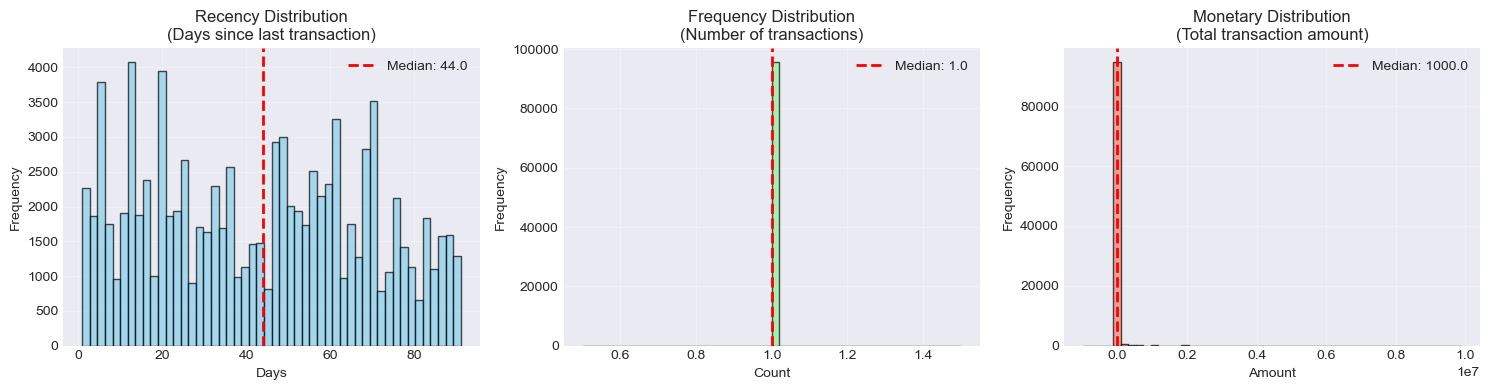


📊 Log-transformed distributions (for highly skewed data):


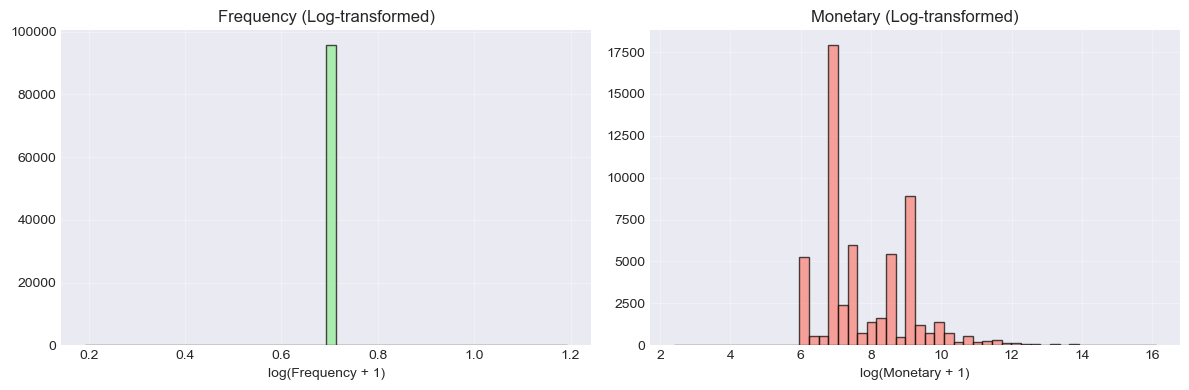

In [15]:
# %% [markdown]
# ## 5. Explore RFM Distributions

# %%
print("📈 Exploring RFM Distributions...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Recency Distribution
axes[0].hist(rfm_df['Recency'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(rfm_df['Recency'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {rfm_df["Recency"].median():.1f}')
axes[0].set_title('Recency Distribution\n(Days since last transaction)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Frequency Distribution (log scale due to skewness)
axes[1].hist(rfm_df['Frequency'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(rfm_df['Frequency'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {rfm_df["Frequency"].median():.1f}')
axes[1].set_title('Frequency Distribution\n(Number of transactions)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Monetary Distribution (log scale due to skewness)
axes[2].hist(rfm_df['Monetary'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[2].axvline(rfm_df['Monetary'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {rfm_df["Monetary"].median():.1f}')
axes[2].set_title('Monetary Distribution\n(Total transaction amount)')
axes[2].set_xlabel('Amount')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log-transformed distributions
print("\n📊 Log-transformed distributions (for highly skewed data):")
rfm_log = rfm_df.copy()
rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm_log['Monetary'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(rfm_log['Frequency_log'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_title('Frequency (Log-transformed)')
axes[0].set_xlabel('log(Frequency + 1)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(rfm_log['Monetary_log'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_title('Monetary (Log-transformed)')
axes[1].set_xlabel('log(Monetary + 1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# %% [markdown]
# ## 6. Handle Skewness and Scale RFM Features

# %%
print("⚙️ Preprocessing RFM features...")

# Create a copy for clustering
rfm_clustering = rfm_df.copy()

# Apply log transformation to handle skewness (except for Recency which is usually less skewed)
rfm_clustering['Frequency_log'] = np.log1p(rfm_clustering['Frequency'])
rfm_clustering['Monetary_log'] = np.log1p(rfm_clustering['Monetary'])

# Select features for clustering
clustering_features = ['Recency', 'Frequency_log', 'Monetary_log']
print(f"\nFeatures selected for clustering: {clustering_features}")

# Standardize the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering[clustering_features])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=[f'{col}_scaled' for col in clustering_features])

print("\n📊 Scaled features statistics:")
display(pd.DataFrame(rfm_scaled, columns=clustering_features).describe())

# Add scaled features to the clustering dataframe
for i, col in enumerate(clustering_features):
    rfm_clustering[f'{col}_scaled'] = rfm_scaled[:, i]

print(f"\n✅ RFM features preprocessed and scaled. Ready for clustering.")

⚙️ Preprocessing RFM features...

Features selected for clustering: ['Recency', 'Frequency_log', 'Monetary_log']

📊 Scaled features statistics:


,Recency,Frequency_log,Monetary_log
count,95662.000,95662.000,57473.000
mean,0.000,0.000,-0.000
std,1.000,0.000,1.000
min,-1.634,0.000,-4.167
25%,-0.930,0.000,-0.741
50%,0.047,0.000,-0.215
75%,0.828,0.000,1.006
max,1.884,0.000,6.243



✅ RFM features preprocessed and scaled. Ready for clustering.


🔍 Determining optimal number of clusters...
🔍 Checking for NaN values in scaled data...
⚠️ Found 38189 NaN values in scaled data
Replacing NaN with 0 for clustering...


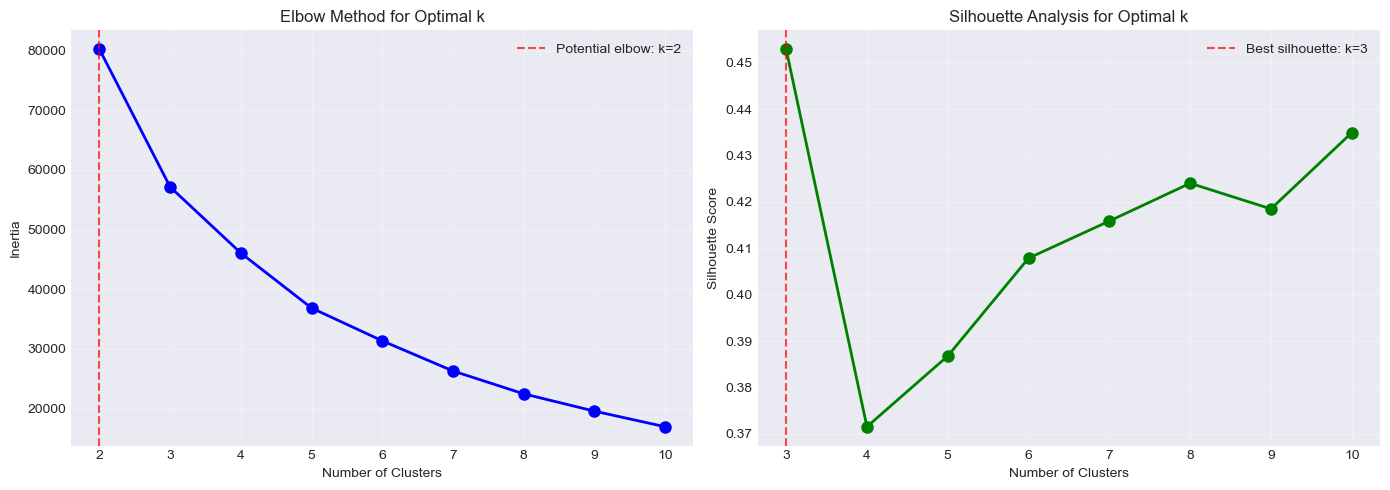


📊 Cluster evaluation results:
  Elbow method suggests: k = 2
  Silhouette method suggests: k = 3

✅ Chosen number of clusters: 3 (as per instructions)


In [22]:
# ## 7. Determine Optimal Number of Clusters

# %%
print("🔍 Determining optimal number of clusters...")

# Check for NaN in scaled data before clustering
print("🔍 Checking for NaN values in scaled data...")
if np.isnan(rfm_scaled).any():
    print(f"⚠️ Found {np.isnan(rfm_scaled).sum()} NaN values in scaled data")
    print("Replacing NaN with 0 for clustering...")
    rfm_scaled = np.nan_to_num(rfm_scaled, nan=0.0)

# Define range of clusters to test
range_n_clusters = range(2, 11)

# Store metrics
inertia_values = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    
    # Calculate inertia
    inertia_values.append(kmeans.inertia_)
    
    # Calculate silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow method
axes[0].plot(range_n_clusters, inertia_values, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Mark the "elbow" (usually where the curve bends)
elbow_diff = np.diff(inertia_values)
elbow_point = np.argmin(elbow_diff) + 2  # +2 because diff reduces length by 1 and we start from 2
axes[0].axvline(x=elbow_point, color='red', linestyle='--', alpha=0.7, 
                label=f'Potential elbow: k={elbow_point}')
axes[0].legend()

# Silhouette score
axes[1].plot(range_n_clusters[1:], silhouette_scores[1:], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis for Optimal k')
axes[1].grid(True, alpha=0.3)

# Find best silhouette score
best_k_silhouette = range_n_clusters[1:][np.argmax(silhouette_scores[1:])]
axes[1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7, 
                label=f'Best silhouette: k={best_k_silhouette}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Cluster evaluation results:")
print(f"  Elbow method suggests: k = {elbow_point}")
print(f"  Silhouette method suggests: k = {best_k_silhouette}")

# Choose number of clusters (using 3 as specified in instructions)
n_clusters_chosen = 3
print(f"\n✅ Chosen number of clusters: {n_clusters_chosen} (as per instructions)")

🔮 Applying K-Means clustering...
🔍 Checking for NaN values before clustering...

✅ Clustering completed. Cluster distribution:


Cluster
0    13704
1    43973
2    37985
Name: count, dtype: int64

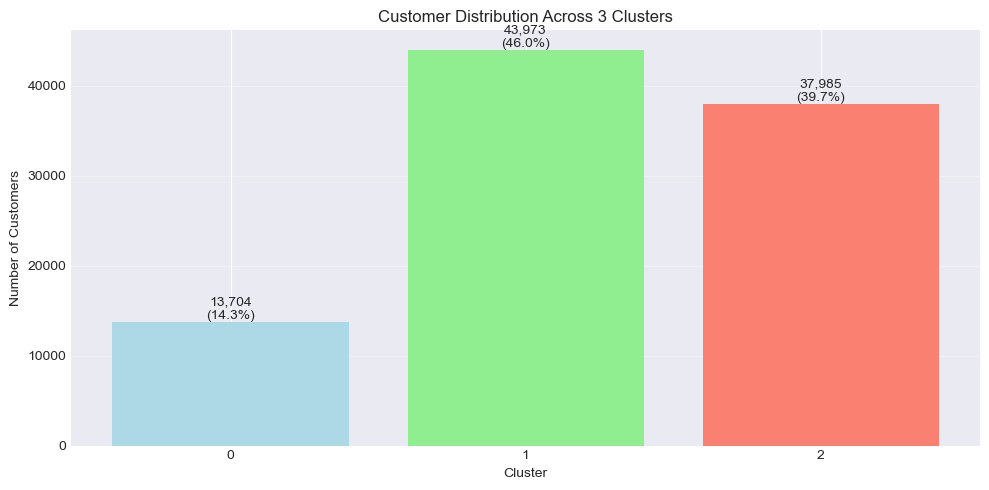

In [27]:
# %% [markdown]
# ## 8. Apply K-Means Clustering

# %%
print("🔮 Applying K-Means clustering...")

# Check for NaN in scaled data
print("🔍 Checking for NaN values before clustering...")
if np.isnan(rfm_scaled).any():
    print(f"⚠️ Found {np.isnan(rfm_scaled).sum()} NaN values in scaled data")
    print("Replacing NaN with 0 for clustering...")
    rfm_scaled = np.nan_to_num(rfm_scaled, nan=0.0)

# Apply K-Means with chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters_chosen, random_state=42, n_init=20)
rfm_clustering['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Add cluster labels to the original RFM dataframe
rfm_df['Cluster'] = rfm_clustering['Cluster']

print(f"\n✅ Clustering completed. Cluster distribution:")
cluster_distribution = rfm_df['Cluster'].value_counts().sort_index()
display(cluster_distribution)

# Plot cluster distribution
plt.figure(figsize=(10, 5))
bars = plt.bar(cluster_distribution.index.astype(str), cluster_distribution.values, 
               color=['lightblue', 'lightgreen', 'salmon', 'gold', 'violet'][:n_clusters_chosen])
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title(f'Customer Distribution Across {n_clusters_chosen} Clusters')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(rfm_df)*100:.1f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

📊 Analyzing cluster characteristics...

📈 Cluster Statistics (RFM values):


Recency                Frequency                Monetary             \
           mean    std min max      mean   std min max      mean        std   
Cluster                                                                       
0        33.470 20.640   1  91     1.000 0.000   1   1 50503.680 321410.420   
1        65.530 13.310  43  91     1.000 0.000   1   1  -190.020   7323.910   
2        19.860 11.580   1  45     1.000 0.000   1   1 -1082.110  12419.710   

                                  
                 min         max  
Cluster                           
0           4500.000 9880000.000  
1        -200000.000   31000.000  
2       -1000000.000    8000.000


CLUSTER PROFILES SUMMARY

🔹 Cluster 0 (n=13,704, 14.3%):
   Recency:    Mean = 33.5 days (SD = 20.6)
   Frequency:  Mean = 1.0 transactions (SD = 0.0)
   Monetary:   Mean = $50503.68 (SD = $321410.42)

🔹 Cluster 1 (n=43,973, 46.0%):
   Recency:    Mean = 65.5 days (SD = 13.3)
   Frequency:  Mean = 1.0 transactions (SD = 0.0)
   Monetary:   Mean = $-190.02 (SD = $7323.91)

🔹 Cluster 2 (n=37,985, 39.7%):
   Recency:    Mean = 19.9 days (SD = 11.6)
   Frequency:  Mean = 1.0 transactions (SD = 0.0)
   Monetary:   Mean = $-1082.11 (SD = $12419.71)

🎨 3D Visualization of Clusters...


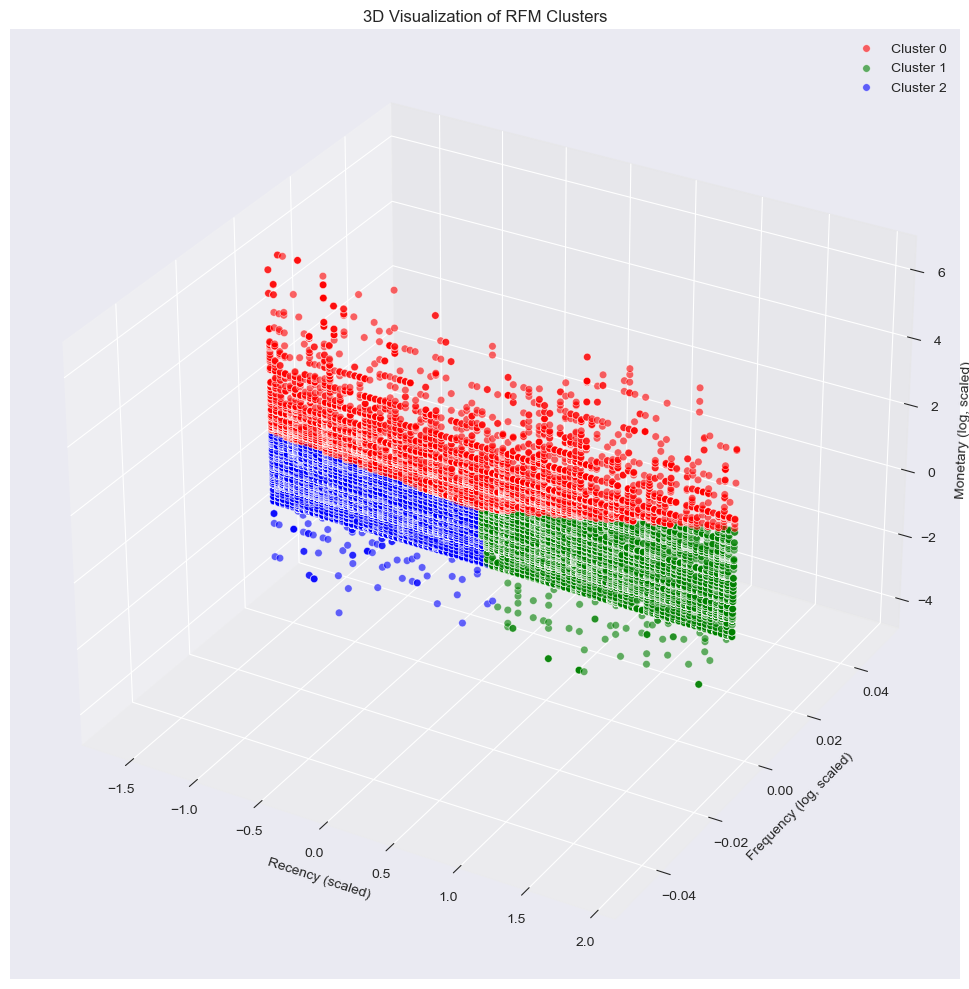


🎨 2D Pairwise Visualizations...


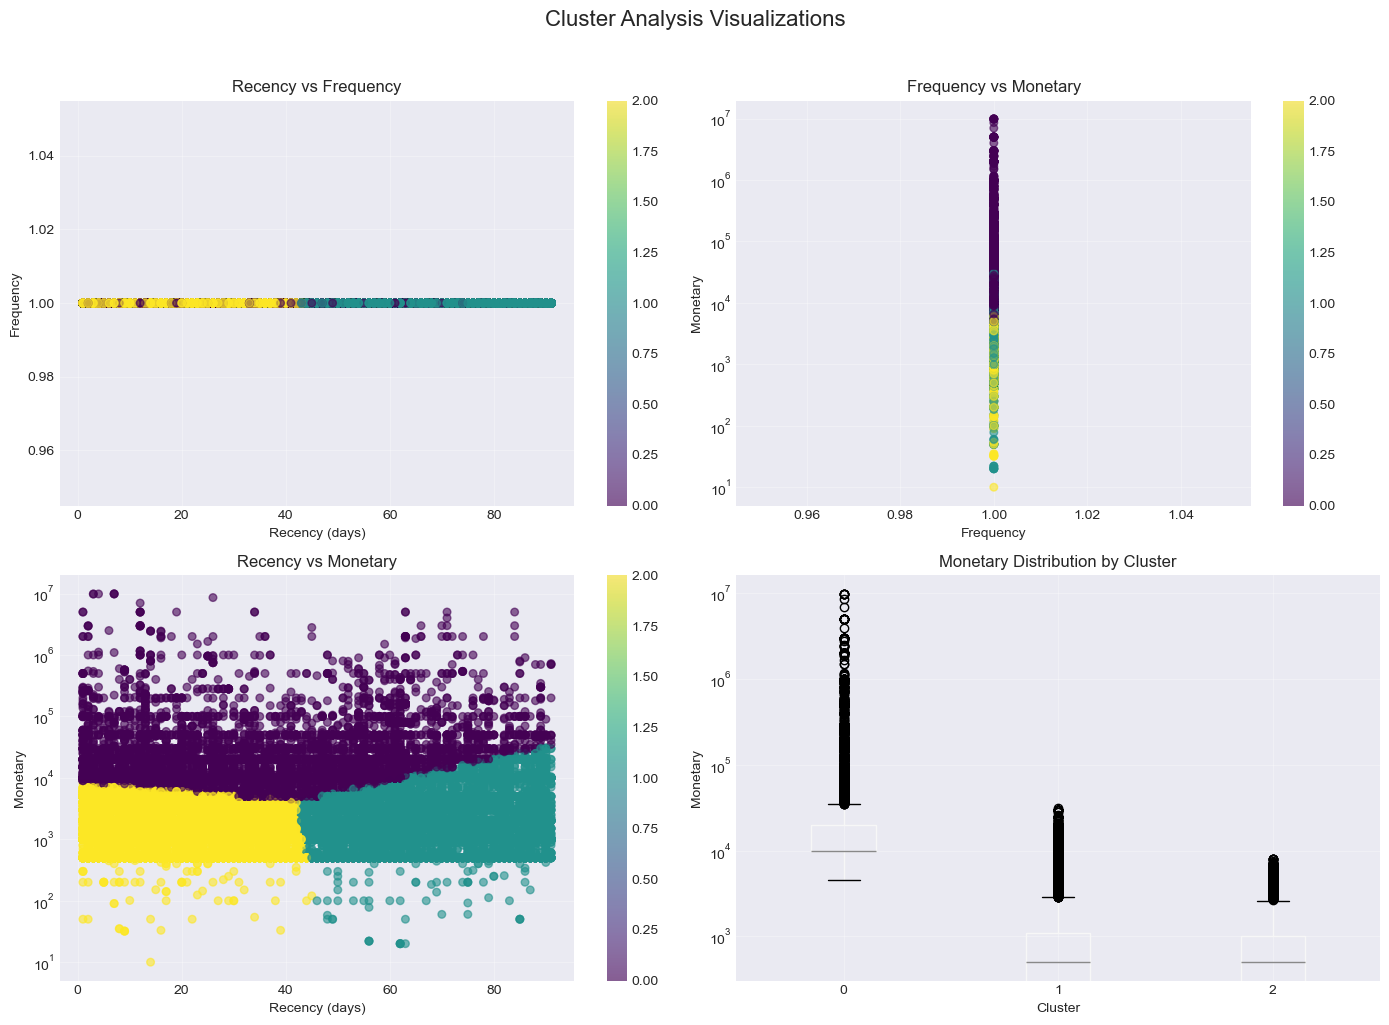

In [24]:
# %% [markdown]
# ## 9. Analyze Cluster Characteristics

# %%
print("📊 Analyzing cluster characteristics...")

# Calculate cluster statistics
cluster_stats = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'std', 'min', 'max'],
    'Frequency': ['mean', 'std', 'min', 'max'],
    'Monetary': ['mean', 'std', 'min', 'max']
}).round(2)

print("\n📈 Cluster Statistics (RFM values):")
display(cluster_stats)

# Create a more readable summary
print("\n" + "=" * 80)
print("CLUSTER PROFILES SUMMARY")
print("=" * 80)

for cluster_id in sorted(rfm_df['Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster_id]
    
    print(f"\n🔹 Cluster {cluster_id} (n={len(cluster_data):,}, {len(cluster_data)/len(rfm_df)*100:.1f}%):")
    print(f"   Recency:    Mean = {cluster_data['Recency'].mean():.1f} days (SD = {cluster_data['Recency'].std():.1f})")
    print(f"   Frequency:  Mean = {cluster_data['Frequency'].mean():.1f} transactions (SD = {cluster_data['Frequency'].std():.1f})")
    print(f"   Monetary:   Mean = ${cluster_data['Monetary'].mean():.2f} (SD = ${cluster_data['Monetary'].std():.2f})")

# Visualize clusters in 3D
print("\n🎨 3D Visualization of Clusters...")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create color map for clusters
colors = ['red', 'green', 'blue', 'orange', 'purple'][:n_clusters_chosen]

for cluster_id, color in zip(range(n_clusters_chosen), colors):
    cluster_data = rfm_clustering[rfm_clustering['Cluster'] == cluster_id]
    
    ax.scatter(cluster_data['Recency_scaled'], 
               cluster_data['Frequency_log_scaled'], 
               cluster_data['Monetary_log_scaled'],
               c=color, label=f'Cluster {cluster_id}', alpha=0.6, s=30, edgecolors='w', linewidth=0.5)

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (log, scaled)')
ax.set_zlabel('Monetary (log, scaled)')
ax.set_title('3D Visualization of RFM Clusters')
ax.legend()
plt.tight_layout()
plt.show()

# 2D Visualizations
print("\n🎨 2D Pairwise Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot 1: Recency vs Frequency
scatter1 = axes[0].scatter(rfm_clustering['Recency'], rfm_clustering['Frequency'], 
                          c=rfm_clustering['Cluster'], cmap='viridis', alpha=0.6, s=30)
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# Plot 2: Frequency vs Monetary
scatter2 = axes[1].scatter(rfm_clustering['Frequency'], rfm_clustering['Monetary'], 
                          c=rfm_clustering['Cluster'], cmap='viridis', alpha=0.6, s=30)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Monetary')
axes[1].set_title('Frequency vs Monetary')
axes[1].set_yscale('log')  # Log scale for better visualization
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

# Plot 3: Recency vs Monetary
scatter3 = axes[2].scatter(rfm_clustering['Recency'], rfm_clustering['Monetary'], 
                          c=rfm_clustering['Cluster'], cmap='viridis', alpha=0.6, s=30)
axes[2].set_xlabel('Recency (days)')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Recency vs Monetary')
axes[2].set_yscale('log')  # Log scale for better visualization
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2])

# Plot 4: Box plot of Monetary by cluster
rfm_df.boxplot(column='Monetary', by='Cluster', ax=axes[3])
axes[3].set_title('Monetary Distribution by Cluster')
axes[3].set_xlabel('Cluster')
axes[3].set_ylabel('Monetary')
axes[3].set_yscale('log')  # Log scale for better visualization
axes[3].grid(True, alpha=0.3)

plt.suptitle('Cluster Analysis Visualizations', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [30]:
# %% [markdown]
# ## 10. Identify High-Risk Cluster

# %%
print("⚠️ Identifying high-risk cluster...")

# Define criteria for high-risk customers
# Typically: High Recency (inactive), Low Frequency, Low Monetary

print("\n📋 Risk assessment based on RFM patterns:")
print("High-risk customers typically have:")
print("  • HIGH Recency (inactive for long time)")
print("  • LOW Frequency (few transactions)")
print("  • LOW Monetary (low transaction amounts)")

# Calculate average RFM values per cluster
cluster_means = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize the means for comparison
cluster_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()

# Handle NaN values in normalized data
if cluster_normalized.isnull().any().any():
    print("⚠️ Found NaN in normalized data. Filling with 0...")
    cluster_normalized = cluster_normalized.fillna(0)

print("\n📊 Normalized cluster means (positive = above average, negative = below average):")
display(cluster_normalized)

# Define risk score based on our criteria
# Higher risk = Higher Recency (inactive) + Lower Frequency + Lower Monetary
cluster_normalized['Risk_Score'] = (
    cluster_normalized['Recency'] * 0.4 +  # Higher weight to Recency (inactivity)
    (-cluster_normalized['Frequency']) * 0.3 +  # Negative because low frequency = high risk
    (-cluster_normalized['Monetary']) * 0.3  # Negative because low monetary = high risk
)

# Check for NaN in Risk_Score
if cluster_normalized['Risk_Score'].isnull().any():
    print("⚠️ Found NaN in Risk_Score. Filling with 0...")
    cluster_normalized['Risk_Score'] = cluster_normalized['Risk_Score'].fillna(0)

print("\n🎯 Calculated risk scores for each cluster:")
display(cluster_normalized[['Risk_Score']].sort_values('Risk_Score', ascending=False))

# Identify high-risk cluster (highest risk score)
# Ensure we don't have NaN in Risk_Score
valid_risk_scores = cluster_normalized['Risk_Score'].dropna()
if len(valid_risk_scores) > 0:
    high_risk_cluster = valid_risk_scores.idxmax()
    print(f"\n🚨 Identified high-risk cluster: Cluster {high_risk_cluster}")
    print(f"   Risk score: {cluster_normalized.loc[high_risk_cluster, 'Risk_Score']:.3f}")
    
    # Validate by looking at actual values
    print(f"\n📊 Characteristics of Cluster {high_risk_cluster}:")
    high_risk_data = rfm_df[rfm_df['Cluster'] == high_risk_cluster]
    print(f"  • Average Recency: {high_risk_data['Recency'].mean():.1f} days")
    print(f"  • Average Frequency: {high_risk_data['Frequency'].mean():.1f} transactions")
    print(f"  • Average Monetary: ${high_risk_data['Monetary'].mean():.2f}")
    
    # Compare with other clusters
    print("\n📈 Comparison with other clusters:")
    for cluster_id in sorted(rfm_df['Cluster'].unique()):
        if cluster_id != high_risk_cluster:
            cluster_data = rfm_df[rfm_df['Cluster'] == cluster_id]
            print(f"\n  Cluster {cluster_id}:")
            print(f"    Recency: {cluster_data['Recency'].mean():.1f} days (vs {high_risk_data['Recency'].mean():.1f})")
            print(f"    Frequency: {cluster_data['Frequency'].mean():.1f} trans (vs {high_risk_data['Frequency'].mean():.1f})")
            print(f"    Monetary: ${cluster_data['Monetary'].mean():.2f} (vs ${high_risk_data['Monetary'].mean():.2f})")
else:
    print("❌ ERROR: No valid risk scores available. All Risk_Score values are NaN.")
    print("This may be due to NaN values in the original data.")
    print("Check your RFM data for missing values.")

⚠️ Identifying high-risk cluster...

📋 Risk assessment based on RFM patterns:
High-risk customers typically have:
  • HIGH Recency (inactive for long time)
  • LOW Frequency (few transactions)
  • LOW Monetary (low transaction amounts)
⚠️ Found NaN in normalized data. Filling with 0...

📊 Normalized cluster means (positive = above average, negative = below average):


,Recency,Frequency,Monetary
Cluster,,,
0,-0.262,0.000,1.155
1,1.105,0.000,-0.562
2,-0.843,0.000,-0.592



🎯 Calculated risk scores for each cluster:


,Risk_Score
Cluster,
1,0.611
2,-0.159
0,-0.451



🚨 Identified high-risk cluster: Cluster 1
   Risk score: 0.611

📊 Characteristics of Cluster 1:
  • Average Recency: 65.5 days
  • Average Frequency: 1.0 transactions
  • Average Monetary: $-190.02

📈 Comparison with other clusters:

  Cluster 0:
    Recency: 33.5 days (vs 65.5)
    Frequency: 1.0 trans (vs 1.0)
    Monetary: $50503.68 (vs $-190.02)

  Cluster 2:
    Recency: 19.9 days (vs 65.5)
    Frequency: 1.0 trans (vs 1.0)
    Monetary: $-1082.11 (vs $-190.02)


🎯 Creating binary target variable...

✅ Target variable created: 'is_high_risk'
High-risk cluster: 1

📊 Target variable distribution:


is_high_risk
0    51689
1    43973
Name: count, dtype: int64


📈 Distribution percentages:
  High-risk customers (is_high_risk = 1): 43,973 (46.0%)
  Low-risk customers (is_high_risk = 0): 51,689 (54.0%)


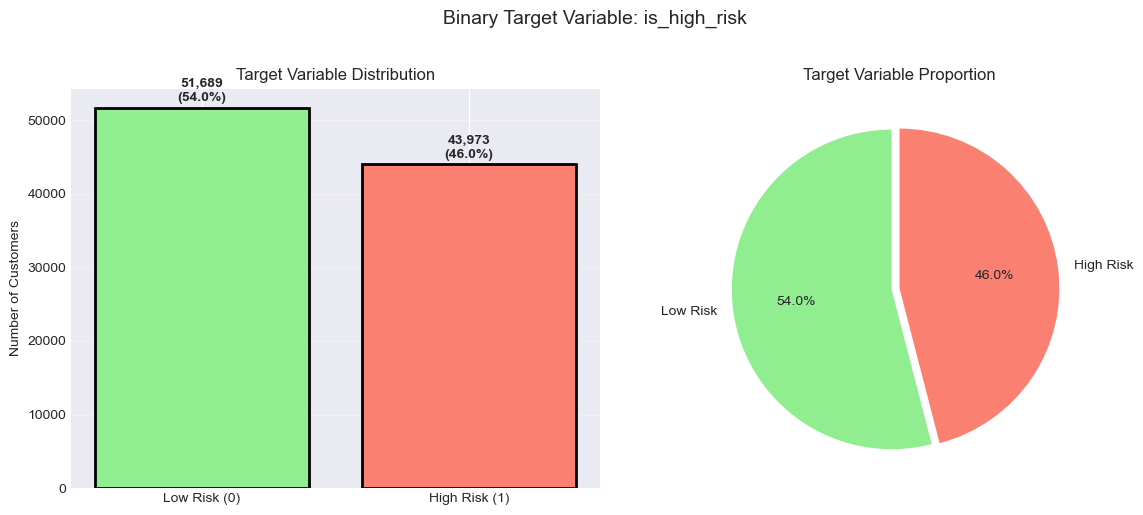

In [35]:
# ## 11. Create Binary Target Variable

# %%
print("🎯 Creating binary target variable...")

# Check if high_risk_cluster is valid (not nan)
if pd.isna(high_risk_cluster):
    print("⚠️ WARNING: high_risk_cluster is NaN. This might be due to NaN values in the data.")
    print("Using cluster with highest Recency as high-risk cluster...")
    
    # Fallback: Use cluster with highest average Recency
    cluster_recency_means = rfm_df.groupby('Cluster')['Recency'].mean()
    high_risk_cluster = cluster_recency_means.idxmax()
    print(f"Fallback: Using Cluster {high_risk_cluster} (highest Recency) as high-risk cluster")

# Create binary target: 1 for high-risk cluster, 0 for others
rfm_df['is_high_risk'] = (rfm_df['Cluster'] == high_risk_cluster).astype(int)

print(f"\n✅ Target variable created: 'is_high_risk'")
print(f"High-risk cluster: {high_risk_cluster}")

print(f"\n📊 Target variable distribution:")
target_distribution = rfm_df['is_high_risk'].value_counts()
display(target_distribution)

# Calculate percentages
total_customers = len(rfm_df)
high_risk_count = target_distribution.get(1, 0)
low_risk_count = target_distribution.get(0, 0)

print(f"\n📈 Distribution percentages:")
print(f"  High-risk customers (is_high_risk = 1): {high_risk_count:,} ({high_risk_count/total_customers*100:.1f}%)")
print(f"  Low-risk customers (is_high_risk = 0): {low_risk_count:,} ({low_risk_count/total_customers*100:.1f}%)")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
axes[0].bar(['Low Risk (0)', 'High Risk (1)'], [low_risk_count, high_risk_count], 
            color=['lightgreen', 'salmon'], edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Target Variable Distribution')
axes[0].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate([low_risk_count, high_risk_count]):
    axes[0].text(i, count + max([low_risk_count, high_risk_count]) * 0.01, 
                f'{count:,}\n({count/total_customers*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie([low_risk_count, high_risk_count], 
            labels=['Low Risk', 'High Risk'],
            colors=['lightgreen', 'salmon'],
            autopct='%1.1f%%',
            startangle=90,
            explode=[0.05, 0])
axes[1].set_title('Target Variable Proportion')

plt.suptitle('Binary Target Variable: is_high_risk', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

🔍 Analyzing differences between high-risk and low-risk customers...

📊 RFM Comparison: High-Risk vs Low-Risk Customers


Recency               Frequency               Monetary  \
                mean    std median      mean   std median      mean   
is_high_risk                                                          
0             23.460 15.740 21.000     1.000 0.000  1.000 12594.520   
1             65.530 13.310 65.000     1.000 0.000  1.000  -190.020   

                                  
                    std   median  
is_high_risk                      
0            167388.530 1000.000  
1              7323.910  500.000


📈 Statistical significance tests (Mann-Whitney U test):

  Recency:
    High-risk mean: 65.53
    Low-risk mean: 23.46
    p-value: 0.000000
    Significant difference

  Frequency:
    High-risk mean: 1.00
    Low-risk mean: 1.00
    p-value: 1.000000
    No significant difference

  Monetary:
    High-risk mean: -190.02
    Low-risk mean: 12594.52
    p-value: 0.000000
    Significant difference


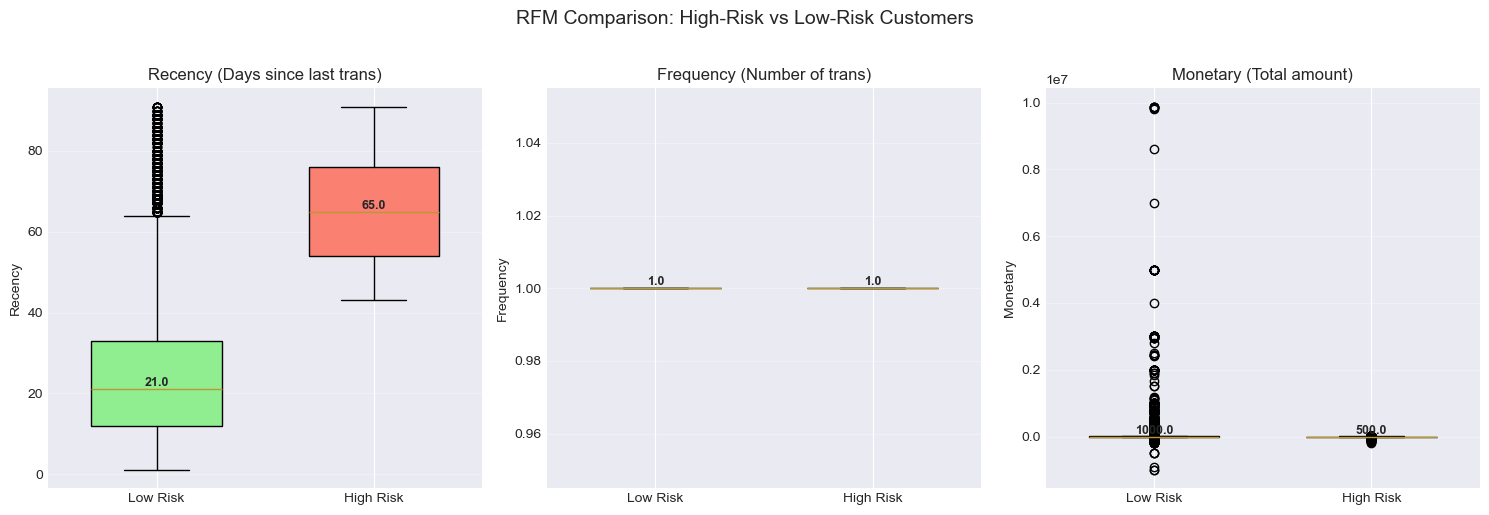

In [32]:
# %% [markdown]
# ## 12. Analyze High-Risk vs Low-Risk Customers

# %%
print("🔍 Analyzing differences between high-risk and low-risk customers...")

# Compare RFM metrics between high-risk and low-risk groups
comparison_stats = rfm_df.groupby('is_high_risk').agg({
    'Recency': ['mean', 'std', 'median'],
    'Frequency': ['mean', 'std', 'median'],
    'Monetary': ['mean', 'std', 'median']
}).round(2)

print("\n📊 RFM Comparison: High-Risk vs Low-Risk Customers")
display(comparison_stats)

# Statistical significance test (Mann-Whitney U test - non-parametric)
from scipy.stats import mannwhitneyu

print("\n📈 Statistical significance tests (Mann-Whitney U test):")

for metric in ['Recency', 'Frequency', 'Monetary']:
    high_risk_values = rfm_df[rfm_df['is_high_risk'] == 1][metric]
    low_risk_values = rfm_df[rfm_df['is_high_risk'] == 0][metric]
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(high_risk_values, low_risk_values, alternative='two-sided')
    
    print(f"\n  {metric}:")
    print(f"    High-risk mean: {high_risk_values.mean():.2f}")
    print(f"    Low-risk mean: {low_risk_values.mean():.2f}")
    print(f"    p-value: {p_value:.6f}")
    print(f"    {'Significant difference' if p_value < 0.05 else 'No significant difference'}")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Recency', 'Frequency', 'Monetary']
titles = ['Recency (Days since last trans)', 'Frequency (Number of trans)', 'Monetary (Total amount)']
colors = ['skyblue', 'lightgreen', 'salmon']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    # Create box plots
    box_data = [rfm_df[rfm_df['is_high_risk'] == 0][metric], 
                rfm_df[rfm_df['is_high_risk'] == 1][metric]]
    
    bp = axes[idx].boxplot(box_data, labels=['Low Risk', 'High Risk'], 
                          patch_artist=True, widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('salmon')
    
    # Customize
    axes[idx].set_title(title)
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add median values
    for i, data in enumerate(box_data):
        median_val = np.median(data)
        axes[idx].text(i+1, median_val, f'{median_val:.1f}', 
                      ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('RFM Comparison: High-Risk vs Low-Risk Customers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [38]:
# %% [markdown]
# ## 13. Integrate Target Variable with Main Dataset

# %%
print("🔄 Integrating target variable with main dataset...")

# First, let's check what our main processed dataset looks like
try:
    # Try to load processed data if it exists
    processed_data = pd.read_csv("../data/processed/processed_data.csv")
    print(f"✅ Loaded processed dataset: {processed_data.shape}")
except FileNotFoundError:
    # If no processed data exists, use our transaction data aggregated at customer level
    print("⚠️ No processed dataset found. Creating customer-level dataset from transactions...")
    
    # Create customer-level features from transaction data
    processed_data = data.groupby(customer_col).agg({
        date_col: ['min', 'max', 'count'],  # First/last transaction, count
        amount_col: ['sum', 'mean', 'std', 'min', 'max']  # Amount statistics
    }).round(2)
    
    # Flatten multi-level columns
    processed_data.columns = ['_'.join(col).strip() for col in processed_data.columns.values]
    processed_data = processed_data.reset_index()
    
    print(f"✅ Created customer-level dataset: {processed_data.shape}")

print("\n🔍 Processed data sample:")
display(processed_data.head())

# Merge the target variable
print(f"\n🔄 Merging target variable with processed data...")
print(f"  RFM DataFrame shape: {rfm_df.shape}")
print(f"  Processed data shape: {processed_data.shape}")

# Ensure we have the customer ID column name
customer_col_processed = [col for col in processed_data.columns if any(x in col.lower() for x in ['cust', 'customer', 'id'])]
if customer_col_processed:
    customer_col_final = customer_col_processed[0]
else:
    # If no customer column found, assume first column is customer ID
    customer_col_final = processed_data.columns[0]

print(f"  Using '{customer_col_final}' as customer ID for merging")

# Merge the datasets
final_data = pd.merge(
    processed_data,
    rfm_df[[customer_col, 'is_high_risk', 'Cluster', 'Recency', 'Frequency', 'Monetary']],
    left_on=customer_col_final,
    right_on=customer_col,
    how='left'
)

print(f"\n✅ Merge completed. Final dataset shape: {final_data.shape}")

# Check for any customers without target (should be none if merge was successful)
missing_target = final_data['is_high_risk'].isnull().sum()
if missing_target > 0:
    print(f"⚠️ Warning: {missing_target} customers have missing target variable")
    # Fill missing with 0 (low risk) as default
    final_data['is_high_risk'] = final_data['is_high_risk'].fillna(0)
else:
    print("🎉 All customers have target variable assigned")

print("\n🔍 Final dataset with target variable:")
print(f"  Columns: {list(final_data.columns)}")
print(f"  Target distribution in final data:")
display(final_data['is_high_risk'].value_counts())


🔄 Integrating target variable with main dataset...
✅ Loaded processed dataset: (95662, 13)

🔍 Processed data sample:


,CustomerId,amount_count,amount_sum,amount_mean,amount_std,amount_min,amount_max,amount_median,most_common_CurrencyCode,most_common_ProviderId,most_common_ProductId,most_common_ProductCategory,most_common_ChannelId
0,TransactionId_1,1,5000.000,5000.000,0.000,5000.000,5000.000,5000.000,UGX,ProviderId_1,ProductId_15,financial_services,ChannelId_3
1,TransactionId_100,1,-100.000,-100.000,0.000,-100.000,-100.000,-100.000,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2
2,TransactionId_1000,1,-5000.000,-5000.000,0.000,-5000.000,-5000.000,-5000.000,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2
3,TransactionId_10000,1,500.000,500.000,0.000,500.000,500.000,500.000,UGX,ProviderId_6,ProductId_3,airtime,ChannelId_3
4,TransactionId_100001,1,-30.000,-30.000,0.000,-30.000,-30.000,-30.000,UGX,ProviderId_4,ProductId_6,financial_services,ChannelId_2



🔄 Merging target variable with processed data...
  RFM DataFrame shape: (95662, 6)
  Processed data shape: (95662, 13)
  Using 'CustomerId' as customer ID for merging

✅ Merge completed. Final dataset shape: (95662, 19)
🎉 All customers have target variable assigned

🔍 Final dataset with target variable:
  Columns: ['CustomerId', 'amount_count', 'amount_sum', 'amount_mean', 'amount_std', 'amount_min', 'amount_max', 'amount_median', 'most_common_CurrencyCode', 'most_common_ProviderId', 'most_common_ProductId', 'most_common_ProductCategory', 'most_common_ChannelId', 'TransactionId', 'is_high_risk', 'Cluster', 'Recency', 'Frequency', 'Monetary']
  Target distribution in final data:


is_high_risk
0    51689
1    43973
Name: count, dtype: int64